# Applied Stochastic Process - Group5 Project

**Author:** *Jichong Yu, Kaiwei Zhang* 

**Instructor**: *Jaehyuk Choi*

In [1]:
%load_ext autoreload
%autoreload 2

import time
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(sys.path.index('')+1, r'D:\python\jupyter\研二\module3-ASP\project\PyFENG')
import pyfeng as pf
import pyfeng.ex as pfex
from pyfeng import garch_2
from scipy import interpolate, integrate
from ipywidgets import interact, FloatSlider, HBox, Label
import seaborn as sns

# Part I: Different numerical methods for the inhomogeneous geometric Brownian motion

The IGBM is described by the Itô SDE

$$
\begin{equation}
d Y(t)=\underbrace{\left(-\frac{1}{\tau} Y(t)+\mu\right)}_{:=F(Y(t))} d t+\underbrace{\sigma Y(t)}_{:=G(Y(t))} d W(t), \quad t \geq 0, \quad Y(0)=Y_{0}, \tag{1}
\end{equation}
$$

where $\tau, \sigma>0, \mu \in \mathbb{R}$ and $W=(W(t))_{t \geq 0}$ is a standard Wiener process defined on the probability space $(\Omega, \mathcal{F}, \mathbb{P})$ with a filtration $\mathcal{F}=(\mathcal{F}(t))_{t \geq 0}$ generated by $W$. The initial value $Y_{0}$ is either a deterministic non-negative constant or an $\mathcal{F}(0)$-measurable non-negative random variable with finite second moment. Since (1) is a linear and autonomous SDE, a unique strong solution process $Y=(Y(t))_{t \geq 0}$ exists. The solution of the homogeneous SDE (if $\left.\mu=0\right)$ corresponds to the well-known GBM. The solution of the inhomogeneous equation can be expressed in terms of the embedded GBM. In particular, applying the variation of constants formula to (1) yields

$$
\begin{equation}
Y(t)=e^{-\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) t+\sigma W(t)}\left(Y_{0}+\mu \int_{0}^{t} e^{\left(\frac{1}{\tau}+\frac{\sigma^{2}}{2}\right) s-\sigma W(s)} d s\right) . \tag{2}
\end{equation}
$$

Since $Y_{0}$ has finite second moment, the mean and variance of the process $Y$, conditioned on the initial value $Y_{0}$, exist. They are explicitly known and given by

$$
\begin{equation}
\begin{aligned}
\mathbb{E}\left[Y(t) \mid Y_{0}\right]=& Y_{0} e^{-\frac{1}{\tau} t}+\mu \tau\left(1-e^{-\frac{1}{\tau} t}\right)
\end{aligned} \tag{3}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\operatorname{Var}\left(Y(t) \mid Y_{0}\right)=&\left\{\begin{array}{lr}
e^{-\frac{1}{\tau} t}\left(2 \mu\left[t Y_{0}-\tau Y_{0}-t \mu \tau\right]+Y_{0}^{2}\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+(\mu \tau)^{2}, & \text { if } \sigma^{2} \tau=1, \\
e^{-\frac{1}{\tau} t}\left(4 \mu \tau\left[\mu \tau-Y_{0}\right]\right)-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2}+2 \mu^{2} \tau t-3(\mu \tau)^{2}+2 \mu \tau Y_{0}+Y_{0}^{2}, & \text { if } \sigma^{2} \tau=2, \\
\frac{(\mu \tau)^{2} \sigma^{2} \tau}{2-\sigma^{2} \tau}+2 \tau \sigma^{2} \frac{\left(Y_{0}-\mu \tau\right) \mu \tau}{1-\sigma^{2} \tau} e^{-\frac{1}{\tau} t}-e^{-\frac{2}{\tau} t}\left(Y_{0}-\mu \tau\right)^{2} \\
+e^{\left(\sigma^{2}-\frac{2}{\tau}\right) t}\left[Y_{0}^{2}-\frac{2 Y_{0} \mu \tau}{1-\sigma^{2} \tau}+\frac{2(\mu \tau)^{2}}{\left(2-\sigma^{2} \tau\right)\left(1-\sigma^{2} \tau\right)}\right], & \text { otherwise }.
\end{array}\right. 
\end{aligned} \tag{4}
\end{equation}
$$

Since $\tau>0$, from (3), it follows that the asymptotic mean of $Y$ exists. It is given by

$$
\mathbb{E}\left[Y_{\infty}\right]:=\lim _{t \rightarrow \infty} \mathbb{E}\left[Y(t) \mid Y_{0}\right]=\mu \tau . \tag{5}
$$

From (4), it follows that, under the condition $\sigma^{2} \tau<2$, the asymptotic variance of $Y$ exists. It is given by

$$
\operatorname{Var}\left(Y_{\infty}\right):=\lim _{t \rightarrow \infty} \operatorname{Var}\left(Y(t) \mid Y_{0}\right)=\frac{(\mu \tau)^{2}}{\frac{2}{\sigma^{2} \tau}-1} . \tag{6}
$$

**Note:** In the context of Garch-diffusion option pricing model, our SDE for $v_t$ is:

$$
\begin{equation}
dv_t = \kappa (\theta - v_t)dt + \nu v_t dZ_t
\end{equation}
$$

so the coefficient mapping from (1) to Garch-diffusion model is:
- $\kappa = \frac{1}{\tau}$ or $\tau = \frac{1}{\kappa}$
- $\theta = \mu\tau$ or $\mu = \kappa\theta$
- $\sigma = \nu$

In [2]:
class IGBM_theoretical():
    def __init__(self, mr, theta, vov):
        self.mr = mr   #k
        self.theta = theta
        self.vov = vov #σ
        
    def cond_mean(self, sigma_0, texp):
        # equation (3)
        coeff = np.exp(-self.mr*texp)
        sigma_t = sigma_0 *  coeff + self.theta * (1 - coeff)
        return sigma_t
        
    def cond_var(self, sigma_0, texp):
        # equation (4)
        coeff1 = self.vov**2 / self.mr
        coeff2 = np.exp(-self.mr*texp)
        if coeff1 == 1:
            var_t = coeff2 * (2*self.mr*self.theta*(texp*sigma_0 - sigma_0/self.mr - texp*self.theta) + sigma_0**2) - coeff2**2 * (sigma_0 - self.theta)**2 + self.theta**2
        elif coeff1 == 2:
            var_t = coeff2 * (4*self.theta*(self.theta-sigma_0)) - coeff**2 * (sigma_0 - self.theta)**2 + 2*self.theta**2*self.mr*texp - 3 * self.theta**2 + 2 * self.theta * sigma_0 + sigma_0**2
        else:
            var_t = self.theta**2 * coeff1 / (2 - coeff1) + 2 * coeff1 * (sigma_0 - self.theta) * self.theta / (1 - coeff1) * coeff2 - coeff2**2 * (sigma_0 - self.theta)**2 + np.exp((self.vov**2-2*self.mr)*texp) * (sigma_0**2 - 2 * sigma_0 * self.theta / (1-coeff1) + 2 * self.theta**2 / (2 - coeff1) / (1 - coeff1))
        return var_t

In [3]:
scheme_name = ['Euler','Milstein','Lie-Trotter1','Lie-Trotter2','Strang1','Strang2','Linear','LogODE']
scheme_num = range(8)
scheme_dict = dict(zip(scheme_num,scheme_name))
print(scheme_dict)

{0: 'Euler', 1: 'Milstein', 2: 'Lie-Trotter1', 3: 'Lie-Trotter2', 4: 'Strang1', 5: 'Strang2', 6: 'Linear', 7: 'LogODE'}


In [4]:
class IGBM_numerical():
    def __init__(self, mr, theta, vov):
        self.mr = mr
        self.theta = theta
        self.vov = vov
        
    def cond_mean(self, sigma_0, texp, dt, scheme):
        i = int(texp / dt)
        coeff1 = (1 - dt*self.mr)**i
        coeff2 = np.exp(-self.mr*texp)
        coeff3 = dt * self.mr / (np.exp(dt * self.mr) - 1)
        if scheme == 0 or scheme == 1:
            # equation (#1) Page 9
            sigma_t = sigma_0 * coeff1 + self.theta * (1 - coeff1)
        elif scheme == 2:
            # equation (#2) Page 9
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3
        elif scheme == 3:
            # equation (#3) Page 9
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)
        elif scheme == 4:
            # equation (#4) Page 9
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*(coeff3*np.exp(dt*self.mr) - dt*self.mr/2)
        elif scheme == 5:
            # equation (#5) Page 9
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr/2)
        elif scheme == 6:
            # equation (#6) & (35) Page 9
            coeff4 = self.mr+self.vov**2/2
            coeff5 = coeff4 * np.sqrt(dt/2) / self.vov
            coeff6 = (coeff4 - self.mr*2) * np.sqrt(dt/2) / self.vov
            L = np.sqrt(sp.pi/2/dt) / self.vov * np.exp(-coeff5**2) * \
                    (sp.special.erfi(coeff5) + sp.special.erfi(coeff6))
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)*L
        elif scheme == 7:
            # equation (#7) & (35) Page 9
            coeff4 = self.mr+self.vov**2/2
            coeff5 = coeff4 * np.sqrt(dt/2) / self.vov
            coeff6 = (coeff4 - self.mr*2) * np.sqrt(dt/2) / self.vov
            L = np.sqrt(sp.pi/2/dt) / self.vov * np.exp(-coeff5**2) * \
                    (sp.special.erfi(coeff5) + sp.special.erfi(coeff6))
            sigma_t = sigma_0 *  coeff2 + self.theta * (1-coeff2)*coeff3*np.exp(dt*self.mr)*L*(1+self.vov**2 * dt/12)
        else:
            raise ValueError(f'Invalid scheme: {scheme}')
            
        return sigma_t

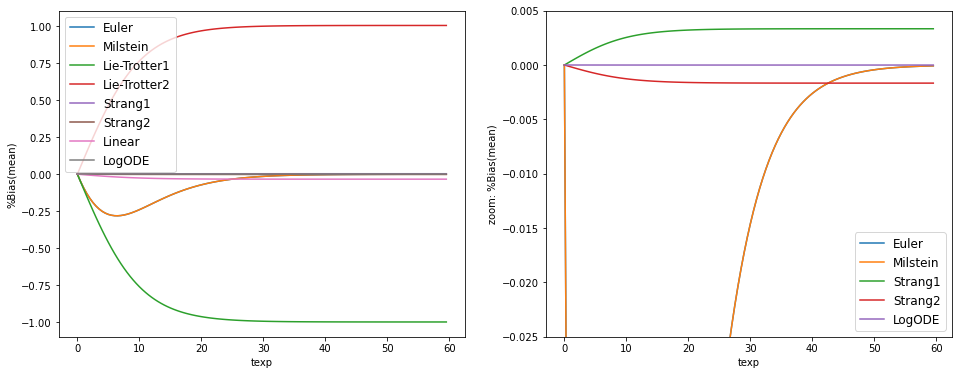

In [5]:
# Figure 1
sigma_0 = 10
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(0, 60, 0.5)

mean_theo = np.zeros(len(texp_arr))
var_theo = np.zeros(len(texp_arr))
mean_error = np.zeros((len(scheme_dict),len(texp_arr)))
var_error = np.zeros((len(scheme_dict),len(texp_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,texp in enumerate(texp_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm_numer = IGBM_numerical(mr, theta, vov)

    for i,texp in enumerate(texp_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100
        
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')

plt.subplot(1,2,2)
for scheme in [0,1,4,5,7]:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.025,0.005])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.show()

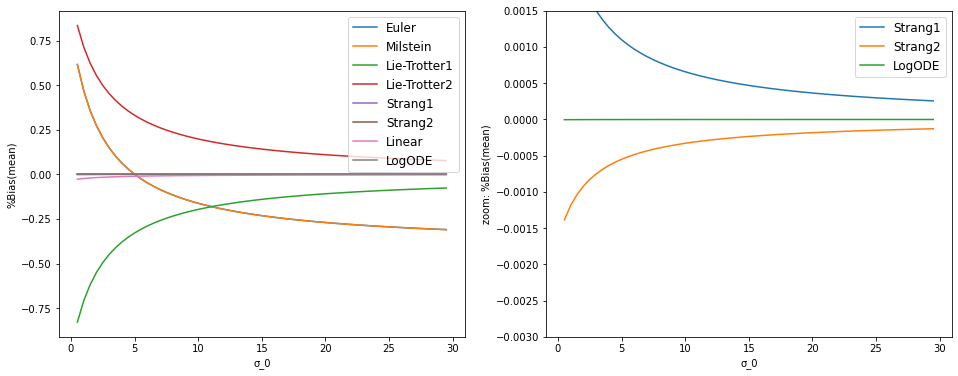

In [6]:
# Figure 2
sigma_arr = np.arange(0.5,30,0.5)
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp = 2

mean_theo = np.zeros(len(sigma_arr))
var_theo = np.zeros(len(sigma_arr))
mean_error = np.zeros((len(scheme_dict),len(sigma_arr)))
var_error = np.zeros((len(scheme_dict),len(sigma_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,sigma_0 in enumerate(sigma_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm_numer = IGBM_numerical(mr, theta, vov)

    for i,sigma_0 in enumerate(sigma_arr):
        var_t = igbm_numer.cond_mean(sigma_0, texp, dt, scheme)
        mean_error[scheme][i] = (var_t - mean_theo[i]) / mean_theo[i] * 100
        
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for scheme in scheme_dict:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('σ_0')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')

plt.subplot(1,2,2)
for scheme in [4,5,7]:
    plt.plot(sigma_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.003,0.0015])
plt.xlabel('σ_0')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.show()

In [7]:
# Figure 1 - MC simulation
sigma_0 = 10
dt = 0.1
mr = 0.2
theta = 5
vov = 0.2
texp_arr = np.arange(0.5, 60, 0.5)

mean_theo = np.zeros(len(texp_arr))
var_theo = np.zeros(len(texp_arr))
mean_error = np.zeros((len(scheme_dict),len(texp_arr)))
var_error = np.zeros((len(scheme_dict),len(texp_arr)))

igbm_theo = IGBM_theoretical(mr, theta, vov)
for i,texp in enumerate(texp_arr):
    mean_theo[i] = igbm_theo.cond_mean(sigma_0,texp)
    var_theo[i] = igbm_theo.cond_var(sigma_0,texp)

for scheme in scheme_dict:
    igbm = garch_2.GarchMcTubikanec2020(sigma_0,vov=vov,mr=mr,theta=theta)
    igbm.set_mc_params(n_path=1000000, dt=dt, rn_seed=None, antithetic=False, scheme=scheme)
    var_arr = igbm.cond_sequence(sigma_0,texp)

    for i,texp in enumerate(texp_arr):
        var_t = var_arr[int(texp/dt)]
        mean = np.mean(var_t)
        var = np.var(var_t)
        mean_error[scheme][i] = (mean - mean_theo[i]) / mean_theo[i] * 100
        var_error[scheme][i] = (var - var_theo[i]) / var_theo[i] * 100

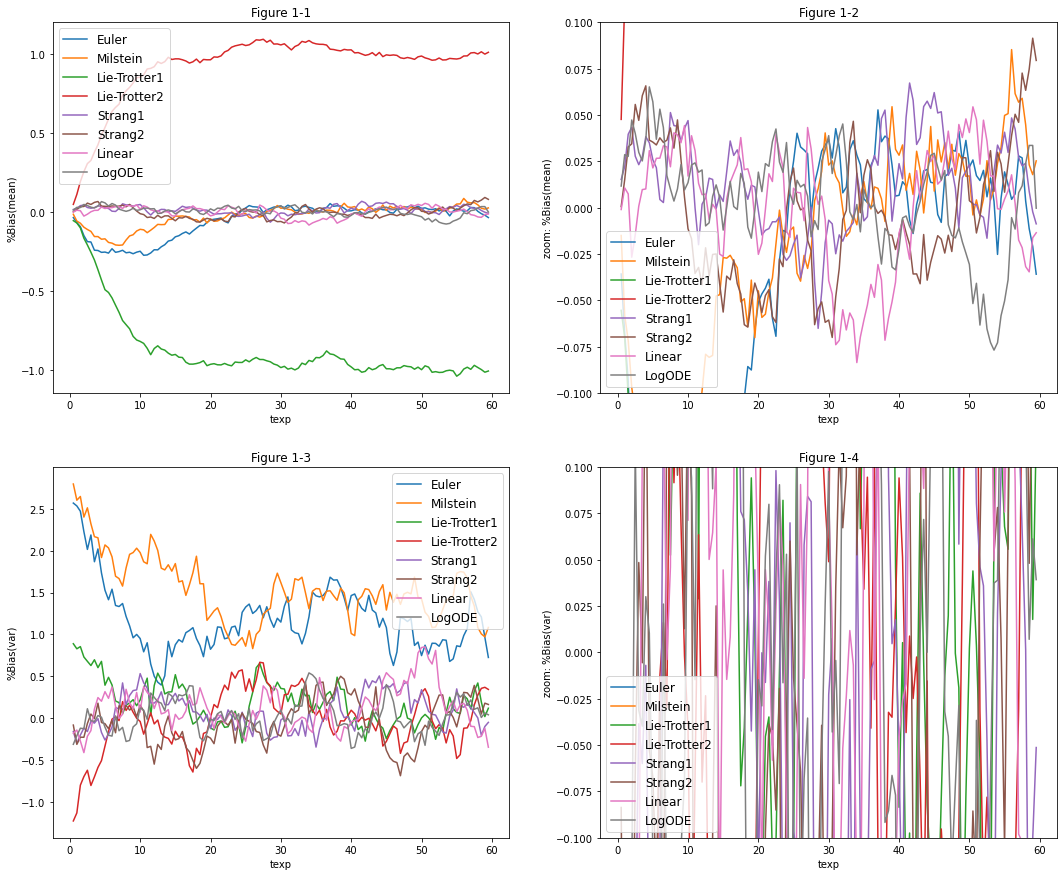

In [8]:
plt.figure(figsize=(18,15))
plt.subplot(2,2,1)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-1')

plt.subplot(2,2,2)
for scheme in scheme_dict:
    plt.plot(texp_arr, mean_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(mean)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-2')

plt.subplot(2,2,3)
for scheme in scheme_dict:
    plt.plot(texp_arr, var_error[scheme],label=scheme_dict[scheme])

plt.xlabel('texp')
plt.ylabel('%Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-3')

plt.subplot(2,2,4)
for scheme in scheme_dict:
    plt.plot(texp_arr, var_error[scheme],label=scheme_dict[scheme])
plt.ylim([-0.1,0.1])
plt.xlabel('texp')
plt.ylabel('zoom: %Bias(var)')

plt.legend(loc=0,fontsize='large')
plt.title('Figure 1-4')

plt.show()

# Part II: Approximation of implied volatilities for the inhomogeneous geometric Brownian motion


## 1. Black-Scholes implied volatility

The basic GARCH Diffusion process, say IGBM, is following:

$$
\begin{align*}
    &dS_t = \mu dt + \sqrt{Y_t}dW_t \\
    &dY_t = a(b-Y_t)dt + \sigma Y_tdB_t \label{eq1.2}\tag{1} \\
    &\qquad where\ dW_tdB_t = \rho dt &
\end{align*}
$$

The Black-Scholes implied volatility (or simply the implied volatility) $IV_t(K, T)$ of, let's say, a European call option with maturity date $T > t$ and strike price$ K > 0 $is defined as the value of the volatility parameter in the Black-Scholes formula such that the Black-Scholes price coincides with the actual option price$ C_t(K, T)$:
$$
 C_t(K, T) = C^{BS}(X_t, K, \tau, IV_t)  \tag{2}
$$
where
$$
 d_1 = \frac{X_t}{IV_t \sqrt{\tau}}+\frac{1}{2} IV_t \sqrt{\tau}
$$
$$
 d_2 = = \frac{X_t}{IV_t \sqrt{\tau}}-\frac{1}{2} IV_t \sqrt{\tau}
$$
$$
 N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d} e^{-\frac{s^2}{2}} ds 
$$
and $ \tau = T - t $ is the option time-to-maturity, $ X_t = \log \left( \frac{S_t e^{(r - \delta)\tau}}{K} \right) $ is the option moneyness.

To further characterize the implied volatility, recall that the price of a European contingent claim is equal to the risk-neutral expectation of its final payoff discounted at the risk-free rate r. In the case of the call option we have:
$$
C_t(K, T) = e^{-r(T-t)} E_t [S_T - K]_+  \tag{3}
$$

Using the definition of the implied volatility and moneyness we can rewrite (3) as:
$$
e^x_t N (d_1(X_t, IV_t, \tau)) - N (d_2(X_t, IV_t, \tau)) = E_t [e^{X_T }- 1]_+ \tag{4}
$$
Under Model (1) the joint dynamics of $X_t $ and $ \sigma_t $ is a time-homogeneous Markov process. Hence, the expectation on the right hand side of (4) is a deterministic function of $X_t$, $ \tau$, and $ \sigma_t $. As a consequence, the implied volatility can be characterized by:
$$
IV_t(K,T) = I(X_t, \tau; \sigma_t),\tag{5}
$$
where $I $ is a deterministic function. It is important to note that the function $I(X,\tau; \sigma) $ does not depend on the risk-free rate and the dividend yield. Hence we can safely assume $ r = \delta = 0 $ when working with implied volatilities instead of option prices. This point is easily deduced from (4) taking into account that the dynamics of $ X_t $ does not depend neither on $ r $ nor on $ \delta $. In applications we should however take into account both the interest rate and the dividend yield to convert strike price $ K $ into moneyness $ X $.
The function $ I(X, \tau; \sigma)$ is generally not available in closed-form except for few special cases. In the case of the stochastic volatility model (1) without jumps it is known that the at-the-money implied volatility converges to the spot volatility as time-to-maturity shrinks to zero (see e.g. Ledoit et al. (2002)):
$$
\lim_{\tau \to 0} I(0, \tau; \sigma) = I(0, 0; \sigma) = \sigma
$$
Taking into account that the implied volatility is known in the limit it is reasonable to consider its Taylor series expansion of $ I(X, T; \sigma) $ around $ X = T = 0 $:
$$
I(X, \tau; \sigma) = \sigma + \frac{\partial I(0, 0; \sigma)}{\partial X} X + \frac{\partial I(0, 0; \sigma)}{\partial \tau} \tau + \ldots \tag{6}
$$

This power series is defined only if the function $ I $ is well-behaved for small $ X $ and $ \tau $, which is not the case if jumps are present (see more about this in the next section). This difficulty can be overcome by introducing an alternative parameterization of implied volatility. Indeed, let


# 2. Asymptotic expansion of implied volatility
In this section we present the main theoretical result of the paper, namely the asymptotic expansion of implied volatility. We begin with a pure diffusion stochastic volatility model without jumps before turning our attention towards jump-diffusion models.

## Garch diffusion case
The next proposition contains our expansion result for implied volatilities in the pure diffusion case.

**Proposition 1**: In Model (1) without jumps assume that for any level of σ the implied volatility function admits a Taylor series representation in some neighborhood of$ X = τ = 0$:
$$
I(X, τ; σ) = \sum_{n,m=0}^{\infty} \frac{\partial^{(n+m)}}{\partial X^n \partial τ^m} I(0, 0; σ) X^n τ^m \tag{8}
$$
then the implied volatility function I has the following asymptotics:
$$
I(θ, τ; σ) = σ + I_1(θ; σ) \sqrt{τ} + I_2(θ; σ) τ + O(τ\sqrt{τ})\tag{9}
$$
where$ I1 $and$ I2$ are functions of the moneyness degree$ θ $and the spot volatility $ σ  $only:
$$
I_1(θ; σ) = -\rho b \frac{θ}{2}\tag{10}
$$
$$
I_2(θ; σ) = \mu - \frac{5}{12}ρ^2b^2σ + \frac{1}{6}b^2σ + \frac{1}{6}ρ^2bb'θ^2 + a + \frac{ρbσ}{4} + \frac{1}{24}ρ^2b^2σ - \frac{1}{12}b^2σ\tag{11}
$$
with $a = a(σ), b = b(σ),$ and b' denotes the derivative of b w.r.t. σ.




$$dv_t = \kappa(\theta - v_t)dt + \nu v_t dZ_t$$  
$$v_t = \sigma_t^2$$
the SDE for $\sigma_t$ is

$$d\sigma_t  = d\sqrt{v_t} = \frac{1}{2\sqrt{v_t}}dv_t - \frac{1}{8v_t\sqrt{v_t}}(dv_t)^2 $$

$$ = -\frac{\kappa}{2} \left(\frac{\theta}{\sigma_t} - \sigma_t\right) dt + \frac{\nu}{2} \sigma_t dZ_t - \frac{\nu^2}{8} \sigma_t dt $$

$$= \frac{1}{2} \left( \frac{\kappa\theta}{\sigma_t} - \left(\kappa + \frac{\nu^2}{4}\right) \sigma_t \right) dt + \frac{\nu}{2} \sigma_t dZ_t.$$

where $dZ_t = \rho dB_t + \sqrt{1-\rho^2}dW_t$
such that, 

$$ a(\sigma_t) = \frac{1}{2} \left( \frac{\kappa\theta}{\sigma_t} - \left(\kappa + \frac{\nu^2}{4}\right) \sigma_t \right)$$

$$ b(\sigma_t) = \frac{\nu}{2} \sigma_t$$

$$ b'(\sigma_t) = \frac{\nu}{2} $$ 

$$I_1(\theta; \sigma) = -\frac{\rho b \theta}{2},$$

$$I_2(\theta; \sigma) = \left( -\frac{5 \rho^2 b^2}{12 \sigma} + \frac{1}{6} \frac{b^2}{\sigma} + \frac{1}{6} \rho^2 bb' \right) \theta^2$$ 

$$+ \frac{a}{2} + \frac{\rho b \sigma}{4} + \frac{1}{24} \frac{\rho^2 b^2}{\sigma} + \frac{1}{12} b^2 - \frac{1}{6} \rho^2 bb',$$

we will compare the exat sigma and approximate sigma around $X = \tau = 0$

In [9]:
import numpy as np
import scipy.stats as spst
from pyfeng import sv_abc as sv
from pyfeng import bsm

In [49]:
class GarchIV2007(sv.SvABC):

    model_type = "GarchDiff"
    var_process = True


    def IV(self, rho ,texp,var0):
        """
        Args:
            var0: initial variance
        Returns:
            mean, variance
        """
        mr, vov, theta = self.mr, self.vov, self.theta

        a = 0.5 * (mr * theta /var0 - (mr + 0.25 * vov * vov) * var0)
        #print(a)
        b = vov * 0.5 * var0
        #print(b)
        b1 = 0.5 * vov

        I1 = -0.5 * rho * b * theta
        c1 = -5/12 * rho**2 * b**2/var0 +b**2/(6 * var0) + rho**2 * b * b1/6
        c2 = 0.5 * a + 0.25 * rho * b *var0 + rho**2 * b**2/(24 * var0) +b**2/12 - rho**2 * b * b1/6
        I2 = c1 * theta**2 + c2
        vart = var0 + I1 * np.sqrt(texp)+ I2 * texp
        
        return vart

    def price(self, strike, spot, texp, rho, cp=1):

        vart = self.IV(rho, texp,self.sigma)

        m_bs = bsm.Bsm(np.sqrt(vart), intr=self.intr, divr=self.divr)
        price = m_bs.price(strike, spot, texp, cp)

        return price
    
    def CK(self,K, texp, theta, sigma, r):
        n = norm.pdf(theta)
        N = norm.cdf(theta)

        a = 0.5 * (mr * theta /var0 - (mr + 0.25 * vov * vov) * var0)
        b = vov * 0.5 * var0
        b1 = 0.5 * vov    
        I1 = -0.5 * rho * b * theta
        c1 = -5/12 * rho**2 * b**2/var0 +b**2/(6 * var0) + rho**2 * b * b1/6
        c2 = 0.5 * a + 0.25 * rho * b *var0 + rho**2 * b**2/(24 * var0) +b**2/12 - rho**2 * b * b1/6
        I2 = c1 * theta**2 + c2

        # 计算A1, A2, A3
        A1 = sigma * (n + theta * N)
        A2 = (1/2) * theta**2 * N**2 * sigma**2 + (1/2) * theta * n * sigma**2 + n * I1
        A3 = theta**3 * N * sigma**3 / 6 + theta**2 * n * sigma**3 / 6 - n * sigma**3 / 24 + (n * theta**2 * I1**2) / (2 * sigma) + (sigma * n * theta * I1) / 2 + n * I2 - sigma * r * (n + theta * N)

        # 计算CK的值
        CK_value = A1 * np.sqrt(texp) + A2 * texp + A3 * texp * np.sqrt(texp)

        return CK_value

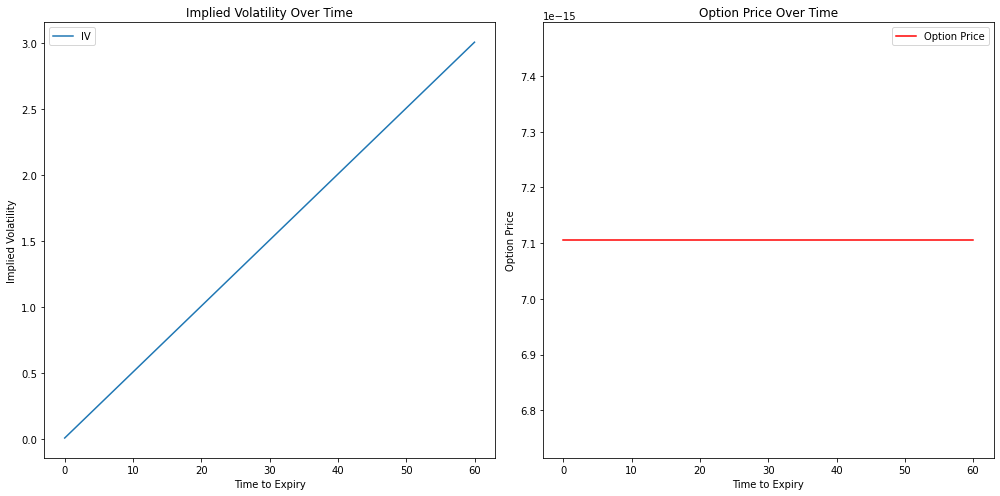

In [50]:
import numpy as np
import matplotlib.pyplot as plt

spot = 100  
strike = 100  
rho = 0.5  
var0 = 0.01  
intr = 0.05  
divr = 0.03  
sigma = 0.2  

# 创建GARCH模型实例
garch_model = GarchIV2007(sigma)

# 计算不同时间点的IV和期权价格
times = np.linspace(0, 60, 100)  # 从0到到期时间的100个时间点
ivs = []
prices = []
CK_values=[]
for texp in times:
    vart = garch_model.IV(rho,texp, var0)
    price = garch_model.price(strike, spot, time, rho)
    CK_values=garch_model.CK(K, texp, theta, sigma, r)
    price
    ivs.append(vart)
    prices.append(price)
    CK_values.append(price)
# 绘制IV随时间变化的图像
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(times, ivs, label='IV')
plt.xlabel('Time to Expiry')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.legend()

# 绘制期权价格随时间变化的图像
plt.subplot(1, 2, 2)
plt.plot(times, prices, label='Option Price', color='r')
plt.xlabel('Time to Expiry')
plt.ylabel('Option Price')
plt.title('Option Price Over Time')
plt.legend()

plt.tight_layout()
plt.show()

allow us to compute the expansion of the call option price. After some simple but tedious algebra we finally obtain:
$$
C K^{-1} = e^{-r\tau}(e^{X_t} N(d_1) - N(d_2)) = A_1 \sqrt{\tau} + A_2 \tau + A_3 \tau \sqrt{\tau} + O(\tau^2)\tag{11}
$$
where
$$
A_1 = σ(n + \theta N),\tag{12}
$$
$$
A_2 = \frac{1}{2}\theta^2 N^2σ^2 + \frac{1}{2}\theta nσ^2 + n I_1,\tag{13}
$$
$$
A_3 = \theta^3 N \frac{σ^3}{6} + \theta^2 n \frac{σ^3}{6} - n \frac{1}{24} σ^3 + \frac{n \theta^2 I_1^2}{2σ} + \frac{\sigma  \theta n I_1 }{2}+ n I_2 - \sigma r (n + \theta N),\tag{14}
$$
and $ n = n(\theta), N = N(\theta) $ are the pdf and cdf of the standard normal distribution evaluated at $ \theta$.


In [12]:
import numpy as np

def CK(self,K, texp, theta, sigma, r):
    n = norm.pdf(theta)
    N = norm.cdf(theta)
    
    a = 0.5 * (mr * theta /var0 - (mr + 0.25 * vov * vov) * var0)
    b = vov * 0.5 * var0
    b1 = 0.5 * vov    
    I1 = -0.5 * rho * b * theta
    c1 = -5/12 * rho**2 * b**2/var0 +b**2/(6 * var0) + rho**2 * b * b1/6
    c2 = 0.5 * a + 0.25 * rho * b *var0 + rho**2 * b**2/(24 * var0) +b**2/12 - rho**2 * b * b1/6
    I2 = c1 * theta**2 + c2
    
    # 计算A1, A2, A3
    A1 = sigma * (n + theta * N)
    A2 = (1/2) * theta**2 * N**2 * sigma**2 + (1/2) * theta * n * sigma**2 + n * I1
    A3 = theta**3 * N * sigma**3 / 6 + theta**2 * n * sigma**3 / 6 - n * sigma**3 / 24 + (n * theta**2 * I1**2) / (2 * sigma) + (sigma * n * theta * I1) / 2 + n * I2 - sigma * r * (n + theta * N)
    
    # 计算CK的值
    CK_value = A1 * np.sqrt(texp) + A2 * texp + A3 * texp * np.sqrt(texp)

    return CK_value


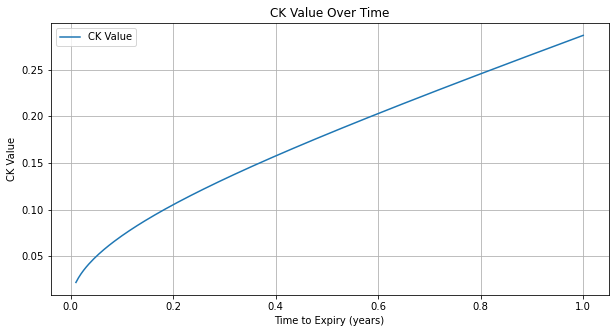

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 定义CK函数
def CK(K, texp, theta, sigma, r, mr, vov, var0, rho):
    n = norm.pdf(theta)
    N = norm.cdf(theta)
    
    a = 0.5 * (mr * theta / var0 - (mr + 0.25 * vov**2) * var0)
    b = vov * 0.5 * var0
    b1 = 0.5 * vov
    
    I1 = -0.5 * rho * b * theta
    c1 = -5/12 * rho**2 * b**2 / var0 + b**2 / (6 * var0) + rho**2 * b * b1 / 6
    c2 = 0.5 * a + 0.25 * rho * b * var0 + rho**2 * b**2 / (24 * var0) + b**2 / 12 - rho**2 * b * b1 / 6
    I2 = c1 * theta**2 + c2
    
    A1 = sigma * (n + theta * N)
    A2 = (1/2) * theta**2 * N**2 * sigma**2 + (1/2) * theta * n * sigma**2 + n * I1
    A3 = theta**3 * N * sigma**3 / 6 + theta**2 * n * sigma**3 / 6 - n * sigma**3 / 24 + (n * theta**2 * I1**2) / (2 * sigma) + (sigma * n * theta * I1) / 2 + n * I2 - sigma * r * (n + theta * N)
    
    CK_value = A1 * np.sqrt(texp) + A2 * texp + A3 * texp * np.sqrt(texp)
    
    return CK_value

# 定义参数
K = 100  # 行权价格
theta = 1  # 这里需要根据实际情况设置
sigma = 0.2  # 波动率
r = 0.05  # 无风险利率
mr = 0.01  # 这里是示例值
vov = 0.1  # 这里是示例值
var0 = 0.01  # 初始方差
rho = -0.8  # 这里是示例值

# 计算不同时间点的CK值
texp_values = np.linspace(0.01, 1, 200)  # 从0.01年到1年的时间间隔
CK_values = [CK(K, t, theta, sigma, r, mr, vov, var0, rho) for t in texp_values]

# 绘制CK随时间变化的图像
plt.figure(figsize=(10, 5))
plt.plot(texp_values, CK_values, label='CK Value')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('CK Value')
plt.title('CK Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import pandas as pd
import os
import chardet

data_folder = 'data'
df_final = pd.DataFrame()

for subdir, dirs, files in os.walk(data_folder):
    for folder in dirs:
        folder_path = os.path.join(data_folder, folder)
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'rb') as f:
                    result = chardet.detect(f.read())
                    encoding = result['encoding']
                df = pd.read_csv(file_path, encoding=encoding)
                df_final = pd.concat([df_final, df], ignore_index=True)
                
df=df_final[df_final['合约代码'].str.slice(start=0, stop=13) == 'IO2301-C-3500'].dropna()
#df=df_final[df_final['合约代码'].str.slice(start=0, stop=2) == 'IO'].dropna()
df

,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,今收盘,今结算,前结算,涨跌1,涨跌2,Delta
196,IO2301-C-3500,350.0,403.0,342.0,12,43.380,156.0,-1.0,403.0,401.00,387.0,16.0,14.00,0.9830
856,IO2301-C-3500,394.2,411.0,383.6,26,103.218,150.0,-6.0,383.6,398.40,401.0,-17.4,-2.60,0.9610
1516,IO2301-C-3500,434.0,476.6,434.0,17,75.956,148.0,-2.0,476.6,475.60,398.4,78.2,77.20,0.9920
2176,IO2301-C-3500,479.6,505.0,479.6,18,88.828,137.0,-11.0,493.4,490.40,475.6,17.8,14.80,0.9940
2836,IO2301-C-3500,521.2,521.2,509.0,23,117.472,128.0,-9.0,513.8,516.80,490.4,23.4,26.40,0.9940
3508,IO2301-C-3500,511.0,532.0,511.0,16,82.910,118.0,-10.0,532.0,522.00,516.8,15.2,5.20,0.9950
4872,IO2301-C-3500,529.0,529.0,529.0,4,20.992,116.0,-2.0,529.0,526.00,520.6,8.4,5.40,0.9970
5554,IO2301-C-3500,541.0,541.0,541.0,1,5.410,115.0,-1.0,541.0,571.80,526.0,15.0,45.80,0.9980
6242,IO2301-C-3500,654.0,660.0,650.6,7,45.086,110.0,-5.0,660.0,651.40,571.8,88.2,79.60,0.9980
6946,IO2301-C-3500,650.0,654.6,639.6,18,116.912,103.0,-7.0,639.6,644.00,651.4,-11.8,-7.40,0.9980
